# Survival Analysis
March 3th 2022

In [1]:
import sys
print(sys.executable)
import numpy as np
import pandas as pd
import os
print(os.getcwd())
from IPython.display import display
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
# Survival modules:
from lifelines import KaplanMeierFitter, CoxPHFitter

/home/razielar/miniconda3/envs/time-series/bin/python
/home/razielar/Documents/git_rep/Machine_learning/time_series_forecasting/coursera_time_series_forecasting/survival_analysis


In [10]:
# Custom functions:
import src.colorsetup
image_path= '../plots/survival_analysis/'

## Input Data

In [3]:
data_path= 'course_data/'
df= pd.read_pickle(data_path+'churndata.pkl')
display(df.head())
print(df.shape)

,id,months,offer,phone,multiple,internet_type,gb_mon,security,backup,protection,...,unlimited,contract,paperless,payment,monthly,total_revenue,satisfaction,churn_value,churn_score,cltv
0,8779-QRDMV,1,None,No,No,DSL,8,No,No,Yes,...,No,Month-to-Month,Yes,Bank Withdrawal,39.65,59.65,3,1,91,5433
1,7495-OOKFY,8,Offer E,Yes,Yes,Fiber Optic,17,No,Yes,No,...,Yes,Month-to-Month,Yes,Credit Card,80.65,1024.10,3,1,69,5302
2,1658-BYGOY,18,Offer D,Yes,Yes,Fiber Optic,52,No,No,No,...,Yes,Month-to-Month,Yes,Bank Withdrawal,95.45,1910.88,2,1,81,3179
3,4598-XLKNJ,25,Offer C,Yes,No,Fiber Optic,12,No,Yes,Yes,...,Yes,Month-to-Month,Yes,Bank Withdrawal,98.50,2995.07,2,1,88,5337
4,4846-WHAFZ,37,Offer C,Yes,Yes,Fiber Optic,14,No,No,No,...,Yes,Month-to-Month,Yes,Bank Withdrawal,76.50,3102.36,2,1,67,2793


(7043, 21)


Percentage of churn: 0.2654


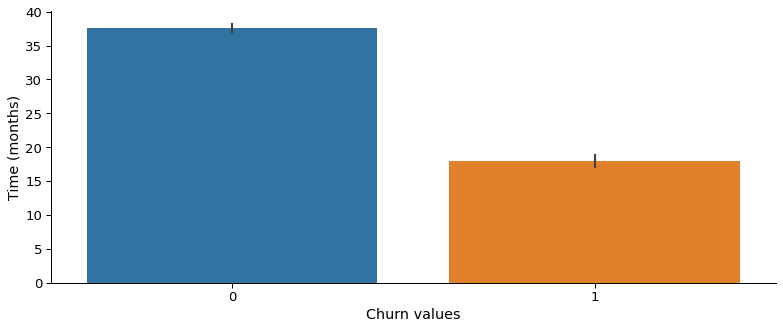

In [4]:
# Plot churn values
print("Percentage of churn: {:.4f}".format(df.churn_value.sum()/df.shape[0]))
sns.barplot(data= df, x= 'churn_value', y= 'months')
plt.xlabel("Churn values")
plt.ylabel("Time (months)")
plt.show()

We observe as expected that months are shorter for churns

## Plot the Kaplan-Meier Curve

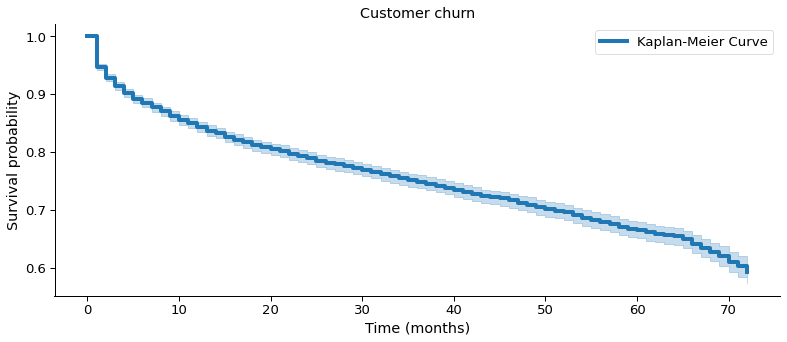

In [5]:
kmf= KaplanMeierFitter()
kmf.fit(df.months, df.churn_value, label= "Kaplan-Meier Curve")
kmf.plot(linewidth= 4)
plt.title("Customer churn")
plt.xlabel("Time (months)")
plt.ylabel("Survival probability")
plt.show()

Counter({'No': 4072, 'Yes': 2971})


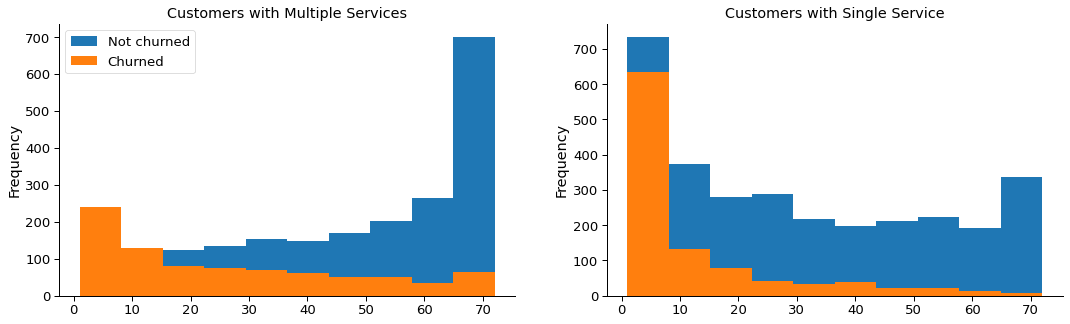

In [6]:
# Let's inspect multiple services variable
print(Counter(df.multiple))
df1= df[df.multiple == 'Yes']
df2= df[df.multiple == 'No']

fig, axes= plt.subplots(1,2)
fig.set_figwidth(18)

df1.groupby('churn_value')['months'].plot(kind= 'hist', ax= axes[0], title= "Customers with Multiple Services")
axes[0].legend(labels= ['Not churned', 'Churned'])
df2.groupby('churn_value')['months'].plot(kind= 'hist', ax= axes[1], title= "Customers with Single Service")

plt.show()

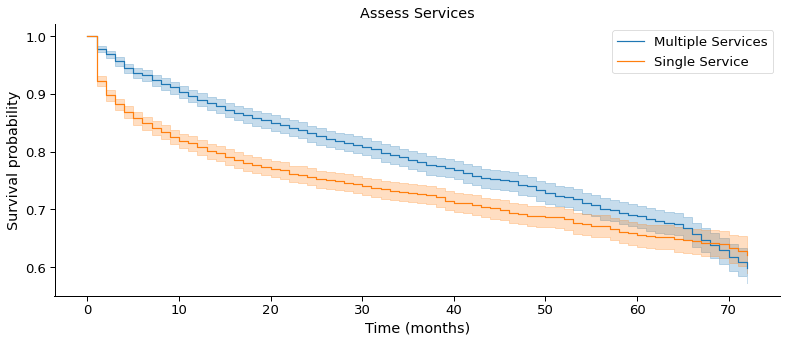

In [12]:
plot_name= 'kaplan-meier-curve.png'

kmf.fit(df1.months, df1.churn_value)
kmf.plot(label= "Multiple Services")
kmf.fit(df2.months, df2.churn_value)
kmf.plot(label= "Single Service")
plt.title("Assess Services")
plt.ylabel('Survival probability')
plt.xlabel('Time (months)')

plt.savefig(image_path+plot_name, transparent= True, bbox_inches= 'tight')
plt.show()

## Cox Proportional Hazard model

In [13]:
dfu= df[['multiple', 'churn_value']]
display(dfu.head())
dfd= pd.get_dummies(dfu, drop_first= True)
display(dfd.head())
dfd['months']= df.months
dfd.rename(columns= {'multiple_Yes': 'multiple_services'}, inplace= True)
dfd.head()

,multiple,churn_value
0,No,1
1,Yes,1
2,Yes,1
3,No,1
4,Yes,1


,churn_value,multiple_Yes
0,1,0
1,1,1
2,1,1
3,1,0
4,1,1


,churn_value,multiple_services,months
0,1,0,1
1,1,1,8
2,1,1,18
3,1,0,25
4,1,1,37


In [14]:
cph= CoxPHFitter()
cph.fit(dfd, duration_col= 'months', event_col= 'churn_value')
cph.print_summary()

/home/razielar/miniconda3/envs/time-series/lib/python3.8/site-packages/lifelines/utils/printer.py:62: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  return summary_df[columns].to_latex(float_format="%." + str(self.decimals) + "f")


<lifelines.CoxPHFitter: fitted with 7043 total observations, 5174 right-censored observations>
             duration col = 'months'
                event col = 'churn_value'
      baseline estimation = breslow
   number of observations = 7043
number of events observed = 1869
   partial log-likelihood = -15641.90
         time fit was run = 2022-03-03 13:14:36 UTC

---
                    coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                 
multiple_services  -0.24       0.79       0.05            -0.33            -0.15                 0.72                 0.86

                      z      p   -log2(p)
covariate                                
multiple_services -5.06 <0.005      21.18
---
Concordance = 0.55
Partial AIC = 31285.81
log-likelihood ratio test = 25.72 on 1 df
-log2(p) of ll-ratio test = 21.27

P-value is significant, and multitple_services coefficient is negative which means it's important (the lower => the better)

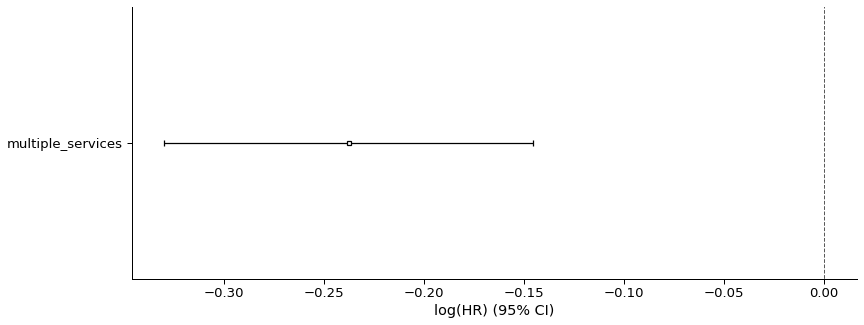

In [15]:
cph.plot()
plt.show()

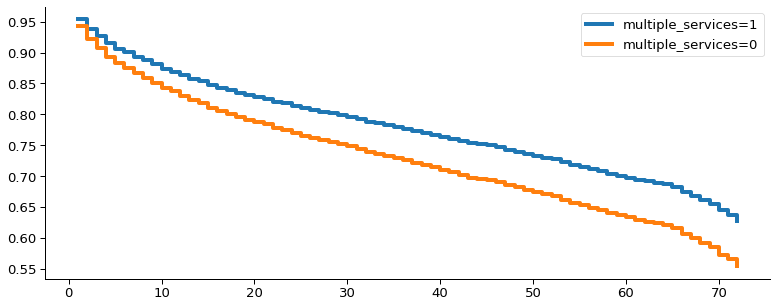

In [16]:
cph.plot_partial_effects_on_outcome(covariates= 'multiple_services', values= [1,0], plot_baseline= False, lw= 4)
plt.show()

## Use more variables to fit Cox-proportional Hazard model

In [17]:
df_more_var= df[['churn_value', 'satisfaction', 'security', 'backup', 'support']]
display(df_more_var.head())
dummy_df= pd.get_dummies(df_more_var, drop_first= True)
display(dummy_df.head())
rename_columns= {'security_Yes': 'security_service', 'backup_Yes': 'backup_service', 'support_Yes': 'support_service'}
dummy_df.rename(columns= rename_columns, inplace= True)
dummy_df['months']= df.months
dummy_df.head()

,churn_value,satisfaction,security,backup,support
0,1,3,No,No,No
1,1,3,No,Yes,No
2,1,2,No,No,No
3,1,2,No,Yes,No
4,1,2,No,No,No


,churn_value,satisfaction,security_Yes,backup_Yes,support_Yes
0,1,3,0,0,0
1,1,3,0,1,0
2,1,2,0,0,0
3,1,2,0,1,0
4,1,2,0,0,0


,churn_value,satisfaction,security_service,backup_service,support_service,months
0,1,3,0,0,0,1
1,1,3,0,1,0,8
2,1,2,0,0,0,18
3,1,2,0,1,0,25
4,1,2,0,0,0,37


In [18]:
new_model= CoxPHFitter().fit(dummy_df, duration_col= 'months', event_col= 'churn_value')
new_model.print_summary()

/home/razielar/miniconda3/envs/time-series/lib/python3.8/site-packages/lifelines/utils/printer.py:62: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  return summary_df[columns].to_latex(float_format="%." + str(self.decimals) + "f")


<lifelines.CoxPHFitter: fitted with 7043 total observations, 5174 right-censored observations>
             duration col = 'months'
                event col = 'churn_value'
      baseline estimation = breslow
   number of observations = 7043
number of events observed = 1869
   partial log-likelihood = -13308.14
         time fit was run = 2022-03-03 13:14:50 UTC

---
                   coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                
satisfaction      -1.30       0.27       0.02            -1.34            -1.25                 0.26                 0.29
security_service  -1.09       0.34       0.07            -1.22            -0.96                 0.29                 0.38
backup_service    -0.63       0.53       0.05            -0.73            -0.52                 0.48                 0.59
support_service   -0.49       0.61       0.06            -0.61            -0.36                 0.54                 0.70

                      z      p   -log2(p)
covariate                                
satisfaction     -55.26 <0.005        inf
security_service -16.46 <0.005     199.73
backup_service   -11.77 <0.005     103.89
support_service   -7.50 <0.005      43.84
---
Concordance = 0.90
Partial AIC = 26624.27
log-likelihood ratio test = 4693.25 on 4 df
-log2(p) of ll-ratio test = inf

Satisfaciton is the most important feature for our model


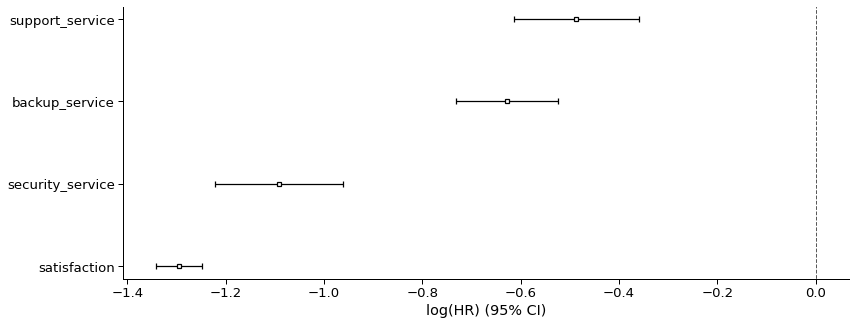

In [20]:
plot_name= 'cph.model.feature.importance.png'

print("Satisfaciton is the most important feature for our model")
new_model.plot()
plt.savefig(image_path+plot_name, transparent= True, bbox_inches= 'tight')
plt.show()

There's a clear difference among the levels of satisfaction


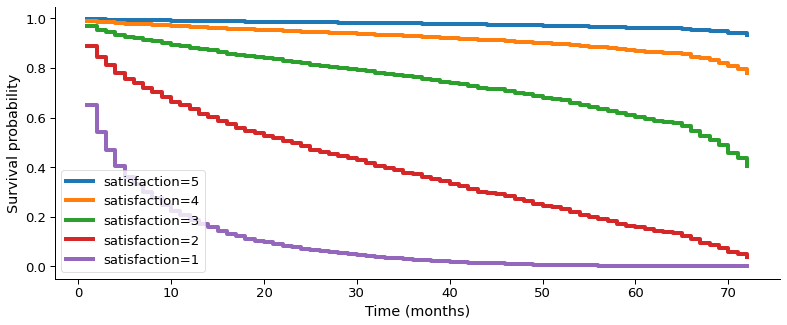

In [23]:
plot_name= 'partial.effects.cph.model.png'

print("There's a clear difference among the levels of satisfaction")
new_model.plot_partial_effects_on_outcome(covariates= 'satisfaction', values= [5,4,3,2,1], plot_baseline= False, lw= 4)

plt.ylabel('Survival probability')
plt.xlabel('Time (months)')
plt.savefig(image_path+plot_name, transparent= True, bbox_inches= 'tight')
plt.show()